In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os


In [2]:
import joblib
import pandas as pd

data_ki = joblib.load('/Users/pinchichen/2025S lab/AI drug project/Catpred/dataset/ki/ki_with_features.joblib')
data_ki.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,log10ki_mean,metabolite_features,protein_features
0,MHTKGPTPQQHDGSALRIGIVHARWNETIIEPLLAGTKAKLLACGV...,uniprot_search,A0A6P8BCR9,O=c1n(C[C@H](O)[C@H](O)[C@H](O)CO)c2nc(O)nc(O)...,0.000002,2.5.1.78,-5.698970,-5.698970,"[0.17249086, -0.23665705, -0.11737049, -0.0940...","[0.026722027, -0.06119407, 0.041440543, -0.109..."
1,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,brenda,P00915,CN1CCN(C(=O)c2ccc(S(N)(=O)=O)cc2)[C@@H](Cc2ccc...,0.000707,4.2.1.1,-3.150581,-3.150581,"[0.4240491, 0.28231123, 0.2642891, -0.7667821,...","[-0.029181704, -0.12635791, 0.10866662, 0.0339..."
2,MLDDIRGFMNTFSETMFMDVINYSLTRDRYDSVFLQRQNYRDLGQL...,brenda,Q9HLD0,C[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O...,0.002990,3.2.1.20,-2.524329,-2.524329,"[0.50005734, 0.3923428, 0.064121775, -0.635894...","[0.02874529, -0.17312695, -0.0026887748, 0.035..."
3,MKLMENIFDLAKANKKKIVLAEGEEERNIRASEEIIKDGIADIILV...,uniprot_search,A0A1L5F6Z9,CCN=C(O)CCN=C(O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O...,0.020000,2.3.1.8,-1.698970,-1.698970,"[0.28353548, 0.018489605, -0.5459905, -0.34693...","[-0.06555556, 0.04763434, 0.031432115, 0.17143..."
4,MAKRIVEPFRIKMVEKIRVPSREEREAALKEAGYNPFLLPSSAVYI...,sabio,P28796,CC(N)C(=O)O,24.500000,4.1.99.1,1.389166,1.419631,"[0.051456872, 0.35619217, 0.10593035, -1.04098...","[0.049294557, -0.043596543, 0.0546125, 0.35600..."


In [3]:
data_ki.rename(columns={'log10ki_mean':'label'},inplace=True)
data_ki.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,label,metabolite_features,protein_features
0,MHTKGPTPQQHDGSALRIGIVHARWNETIIEPLLAGTKAKLLACGV...,uniprot_search,A0A6P8BCR9,O=c1n(C[C@H](O)[C@H](O)[C@H](O)CO)c2nc(O)nc(O)...,0.000002,2.5.1.78,-5.698970,-5.698970,"[0.17249086, -0.23665705, -0.11737049, -0.0940...","[0.026722027, -0.06119407, 0.041440543, -0.109..."
1,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,brenda,P00915,CN1CCN(C(=O)c2ccc(S(N)(=O)=O)cc2)[C@@H](Cc2ccc...,0.000707,4.2.1.1,-3.150581,-3.150581,"[0.4240491, 0.28231123, 0.2642891, -0.7667821,...","[-0.029181704, -0.12635791, 0.10866662, 0.0339..."
2,MLDDIRGFMNTFSETMFMDVINYSLTRDRYDSVFLQRQNYRDLGQL...,brenda,Q9HLD0,C[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O...,0.002990,3.2.1.20,-2.524329,-2.524329,"[0.50005734, 0.3923428, 0.064121775, -0.635894...","[0.02874529, -0.17312695, -0.0026887748, 0.035..."
3,MKLMENIFDLAKANKKKIVLAEGEEERNIRASEEIIKDGIADIILV...,uniprot_search,A0A1L5F6Z9,CCN=C(O)CCN=C(O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O...,0.020000,2.3.1.8,-1.698970,-1.698970,"[0.28353548, 0.018489605, -0.5459905, -0.34693...","[-0.06555556, 0.04763434, 0.031432115, 0.17143..."
4,MAKRIVEPFRIKMVEKIRVPSREEREAALKEAGYNPFLLPSSAVYI...,sabio,P28796,CC(N)C(=O)O,24.500000,4.1.99.1,1.389166,1.419631,"[0.051456872, 0.35619217, 0.10593035, -1.04098...","[0.049294557, -0.043596543, 0.0546125, 0.35600..."


In [4]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [5]:
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data_ki, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [6]:
import torch.nn as nn
import torch

# Define Diffusion Generative Model for Regression
class DiffusionGenerativeModel(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, hidden_dim, num_timesteps):
        super(DiffusionGenerativeModel, self).__init__()
        self.num_timesteps = num_timesteps
        self.mol_encoder = nn.Linear(mol_input_dim, hidden_dim)
        self.protein_encoder = nn.Linear(protein_input_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.denoise_model = nn.Linear(hidden_dim * 2, hidden_dim)
        self.regressor = nn.Linear(hidden_dim, 1)  # Regression layer
        self.activation = nn.ReLU()

        # Embedding for timesteps
        self.timestep_embedding = nn.Embedding(num_timesteps, hidden_dim * 2)

    def forward(self, mol_features, protein_features, t):
        # Encode mol and protein features
        mol_embedding = self.activation(self.mol_encoder(mol_features))
        protein_embedding = self.activation(self.protein_encoder(protein_features))

        # Concatenate embeddings
        combined = torch.cat((mol_embedding, protein_embedding), dim=-1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)

        # Add learnable timestep embedding
        t_embedding = self.timestep_embedding(t.long())
        combined += t_embedding

        # Denoise process
        denoised = self.activation(self.denoise_model(combined))

        # Regression layer
        output = self.regressor(denoised)  # Predict continuous values
        return output

    def add_noise(self, x, noise_level=0.1):
        noise = noise_level * torch.randn_like(x)
        return x + noise


In [7]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr

train_history = pd.DataFrame(columns=[ 'epoch',
    'Train Loss', 'Train MSE', 'Train MAE', 'Train RMSE', 'Train R2', 'Train Pearson', 'Train Median_AE', 'Train Explained_VAR'
    'Val Loss', 'Val MSE', 'Val MAE', 'Val RMSE', 'Val R2', 'Val Pearson', 'Val Median_AE', 'Val Explained_VAR'])
# Verify feature dimensions
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = DiffusionGenerativeModel(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim, hidden_dim=512, num_timesteps=num_timesteps)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training and Validation Loop
for epoch in range(2000):
    model.train()
    total_loss = 0.0
    val_total_loss = 0.0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        # Add noise to the features
        noisy_mol_features = model.add_noise(mol_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        optimizer.zero_grad()
        outputs = model(noisy_mol_features, noisy_protein_features, torch.randint(0, num_timesteps, (mol_features.size(0),)).to(device)).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_mse = ((torch.tensor(train_predictions) - torch.tensor(train_labels))**2).mean().item()
    train_mae = torch.abs(torch.tensor(train_predictions) - torch.tensor(train_labels)).mean().item()
    train_rmse = torch.sqrt((torch.tensor(train_predictions) - torch.tensor(train_labels)) ** 2).mean().item()
    train_r2 = r2_score(np.array(train_labels), np.array(train_predictions))
    train_pearson_corr, _ = pearsonr(np.array(train_labels), np.array(train_predictions))
    train_median_ae = median_absolute_error(np.array(train_labels), np.array(train_predictions))
    train_explained_var = explained_variance_score(np.array(train_labels), np.array(train_predictions))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {total_loss / len(train_loader):.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")

    # Validation
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            mol_features = batch['metabolite_features'].to(device)
            protein_features = batch['protein_features'].to(device)
            labels = batch['label'].to(device)

            # Add noise to the features
            noisy_mol_features = model.add_noise(mol_features, noise_level=0.1)
            noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

            outputs = model(noisy_mol_features, noisy_protein_features, torch.randint(0, num_timesteps, (mol_features.size(0),)).to(device)).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_mse = ((torch.tensor(val_predictions) - torch.tensor(val_labels))**2).mean().item()
    val_mae = torch.abs(torch.tensor(val_predictions) - torch.tensor(val_labels)).mean().item()
    val_rmse = torch.sqrt((torch.tensor(val_predictions) - torch.tensor(val_labels)) ** 2).mean().item()
    val_r2 = r2_score(np.array(val_labels), np.array(val_predictions))
    val_pearson_corr, _ = pearsonr(np.array(val_labels), np.array(val_predictions))
    val_median_ae = median_absolute_error(np.array(val_labels), np.array(val_predictions))
    val_explained_var = explained_variance_score(np.array(val_labels), np.array(val_predictions))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}")

    # Save metrics to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train MSE': train_mse, 'Train MAE': train_mae, 'Train RMSE': train_rmse, 'Train R2': train_r2, 'Train Pearson': train_pearson_corr, 'Train Median_AE': train_median_ae, 'Train Explained_VAR': train_explained_var, 
               'Val Loss': val_total_loss / len(val_loader), 'Val MSE': val_mse, 'Val MAE': val_mae, 'Val RMSE': val_rmse, 'Val R2': val_r2, 'Val Pearson': val_pearson_corr, 'Val Median_AE': val_median_ae, 'Val Explained_VAR': val_explained_var}
    train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)




Training Epoch 1: 100%|██████████| 261/261 [00:01<00:00, 133.30it/s]
/var/folders/yz/c1z6m9_d5d3f80sywjc3rqsc0000gn/T/ipykernel_17914/374893312.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 0 - Train Loss: 2.8376, Train MSE: 2.8378, Train MAE: 1.3324
Epoch 0 - Validation Loss: 2.5444, Validation MSE: 2.5454, Validation MAE: 1.2457


Training Epoch 11: 100%|██████████| 261/261 [00:02<00:00, 125.40it/s]


Epoch 10 - Train Loss: 1.9936, Train MSE: 1.9935, Train MAE: 1.1014
Epoch 10 - Validation Loss: 2.3666, Validation MSE: 2.3680, Validation MAE: 1.1921


Training Epoch 21: 100%|██████████| 261/261 [00:02<00:00, 117.51it/s]


Epoch 20 - Train Loss: 1.6147, Train MSE: 1.6149, Train MAE: 0.9925
Epoch 20 - Validation Loss: 2.0403, Validation MSE: 2.0409, Validation MAE: 1.0968


Training Epoch 31: 100%|██████████| 261/261 [00:02<00:00, 121.65it/s]


Epoch 30 - Train Loss: 1.3939, Train MSE: 1.3938, Train MAE: 0.9129
Epoch 30 - Validation Loss: 1.9411, Validation MSE: 1.9415, Validation MAE: 1.0728


Training Epoch 41: 100%|██████████| 261/261 [00:02<00:00, 126.11it/s]


Epoch 40 - Train Loss: 1.2239, Train MSE: 1.2238, Train MAE: 0.8520
Epoch 40 - Validation Loss: 1.8650, Validation MSE: 1.8663, Validation MAE: 1.0499


Training Epoch 51: 100%|██████████| 261/261 [00:02<00:00, 121.29it/s]


Epoch 50 - Train Loss: 1.0730, Train MSE: 1.0728, Train MAE: 0.7989
Epoch 50 - Validation Loss: 1.8484, Validation MSE: 1.8495, Validation MAE: 1.0348


Training Epoch 61: 100%|██████████| 261/261 [00:02<00:00, 125.06it/s]


Epoch 60 - Train Loss: 0.9712, Train MSE: 0.9712, Train MAE: 0.7616
Epoch 60 - Validation Loss: 1.7629, Validation MSE: 1.7635, Validation MAE: 1.0034


Training Epoch 71: 100%|██████████| 261/261 [00:02<00:00, 103.96it/s]


Epoch 70 - Train Loss: 0.8915, Train MSE: 0.8916, Train MAE: 0.7255
Epoch 70 - Validation Loss: 1.7394, Validation MSE: 1.7407, Validation MAE: 0.9978


Training Epoch 81: 100%|██████████| 261/261 [00:02<00:00, 121.75it/s]


Epoch 80 - Train Loss: 0.8139, Train MSE: 0.8139, Train MAE: 0.6910
Epoch 80 - Validation Loss: 1.7497, Validation MSE: 1.7513, Validation MAE: 0.9995


Training Epoch 91: 100%|██████████| 261/261 [00:02<00:00, 116.67it/s]


Epoch 90 - Train Loss: 0.7517, Train MSE: 0.7518, Train MAE: 0.6706
Epoch 90 - Validation Loss: 1.7429, Validation MSE: 1.7443, Validation MAE: 0.9956


Training Epoch 101: 100%|██████████| 261/261 [00:02<00:00, 122.52it/s]


Epoch 100 - Train Loss: 0.6746, Train MSE: 0.6745, Train MAE: 0.6353
Epoch 100 - Validation Loss: 1.7056, Validation MSE: 1.7073, Validation MAE: 0.9830


Training Epoch 111: 100%|██████████| 261/261 [00:02<00:00, 109.26it/s]


Epoch 110 - Train Loss: 0.6587, Train MSE: 0.6587, Train MAE: 0.6268
Epoch 110 - Validation Loss: 1.7486, Validation MSE: 1.7500, Validation MAE: 0.9942


Training Epoch 121: 100%|██████████| 261/261 [00:06<00:00, 41.93it/s]


Epoch 120 - Train Loss: 0.6071, Train MSE: 0.6071, Train MAE: 0.5985
Epoch 120 - Validation Loss: 1.7165, Validation MSE: 1.7177, Validation MAE: 0.9849


Training Epoch 131: 100%|██████████| 261/261 [00:02<00:00, 88.84it/s] 


Epoch 130 - Train Loss: 0.5812, Train MSE: 0.5812, Train MAE: 0.5837
Epoch 130 - Validation Loss: 1.6709, Validation MSE: 1.6721, Validation MAE: 0.9675


Training Epoch 141: 100%|██████████| 261/261 [00:04<00:00, 52.32it/s]


Epoch 140 - Train Loss: 0.5458, Train MSE: 0.5458, Train MAE: 0.5691
Epoch 140 - Validation Loss: 1.6828, Validation MSE: 1.6843, Validation MAE: 0.9749


Training Epoch 151: 100%|██████████| 261/261 [00:03<00:00, 72.41it/s]


Epoch 150 - Train Loss: 0.5297, Train MSE: 0.5297, Train MAE: 0.5558
Epoch 150 - Validation Loss: 1.7715, Validation MSE: 1.7732, Validation MAE: 0.9836


Training Epoch 161: 100%|██████████| 261/261 [17:13<00:00,  3.96s/it]


Epoch 160 - Train Loss: 0.5075, Train MSE: 0.5075, Train MAE: 0.5448
Epoch 160 - Validation Loss: 1.7064, Validation MSE: 1.7077, Validation MAE: 0.9736


Training Epoch 171: 100%|██████████| 261/261 [00:02<00:00, 117.41it/s]


Epoch 170 - Train Loss: 0.4805, Train MSE: 0.4805, Train MAE: 0.5303
Epoch 170 - Validation Loss: 1.6872, Validation MSE: 1.6883, Validation MAE: 0.9658


Training Epoch 181: 100%|██████████| 261/261 [00:02<00:00, 127.21it/s]


Epoch 180 - Train Loss: 0.4547, Train MSE: 0.4547, Train MAE: 0.5175
Epoch 180 - Validation Loss: 1.6514, Validation MSE: 1.6525, Validation MAE: 0.9679


Training Epoch 191: 100%|██████████| 261/261 [00:02<00:00, 122.48it/s]


Epoch 190 - Train Loss: 0.4478, Train MSE: 0.4478, Train MAE: 0.5134
Epoch 190 - Validation Loss: 1.7001, Validation MSE: 1.7018, Validation MAE: 0.9784


Training Epoch 201: 100%|██████████| 261/261 [00:02<00:00, 118.61it/s]


Epoch 200 - Train Loss: 0.4398, Train MSE: 0.4398, Train MAE: 0.5078
Epoch 200 - Validation Loss: 1.7639, Validation MSE: 1.7653, Validation MAE: 0.9799


Training Epoch 211: 100%|██████████| 261/261 [00:02<00:00, 114.94it/s]


Epoch 210 - Train Loss: 0.4210, Train MSE: 0.4210, Train MAE: 0.4970
Epoch 210 - Validation Loss: 1.7310, Validation MSE: 1.7325, Validation MAE: 0.9655


Training Epoch 221: 100%|██████████| 261/261 [00:02<00:00, 110.81it/s]


Epoch 220 - Train Loss: 0.4136, Train MSE: 0.4136, Train MAE: 0.4930
Epoch 220 - Validation Loss: 1.7029, Validation MSE: 1.7040, Validation MAE: 0.9587


Training Epoch 231: 100%|██████████| 261/261 [00:02<00:00, 127.19it/s]


Epoch 230 - Train Loss: 0.3867, Train MSE: 0.3867, Train MAE: 0.4774
Epoch 230 - Validation Loss: 1.6792, Validation MSE: 1.6806, Validation MAE: 0.9671


Training Epoch 241: 100%|██████████| 261/261 [00:02<00:00, 112.10it/s]


Epoch 240 - Train Loss: 0.3891, Train MSE: 0.3891, Train MAE: 0.4790
Epoch 240 - Validation Loss: 1.6567, Validation MSE: 1.6580, Validation MAE: 0.9519


Training Epoch 251: 100%|██████████| 261/261 [00:02<00:00, 105.22it/s]


Epoch 250 - Train Loss: 0.3700, Train MSE: 0.3700, Train MAE: 0.4652
Epoch 250 - Validation Loss: 1.6527, Validation MSE: 1.6538, Validation MAE: 0.9487


Training Epoch 261: 100%|██████████| 261/261 [00:02<00:00, 102.75it/s]


Epoch 260 - Train Loss: 0.3806, Train MSE: 0.3806, Train MAE: 0.4692
Epoch 260 - Validation Loss: 1.6855, Validation MSE: 1.6867, Validation MAE: 0.9615


Training Epoch 271: 100%|██████████| 261/261 [00:02<00:00, 110.05it/s]


Epoch 270 - Train Loss: 0.3543, Train MSE: 0.3542, Train MAE: 0.4575
Epoch 270 - Validation Loss: 1.7054, Validation MSE: 1.7068, Validation MAE: 0.9634


Training Epoch 281: 100%|██████████| 261/261 [00:02<00:00, 112.73it/s]


Epoch 280 - Train Loss: 0.3405, Train MSE: 0.3406, Train MAE: 0.4453
Epoch 280 - Validation Loss: 1.6730, Validation MSE: 1.6745, Validation MAE: 0.9488


Training Epoch 291: 100%|██████████| 261/261 [00:02<00:00, 108.43it/s]


Epoch 290 - Train Loss: 0.3463, Train MSE: 0.3463, Train MAE: 0.4454
Epoch 290 - Validation Loss: 1.6438, Validation MSE: 1.6453, Validation MAE: 0.9438


Training Epoch 301: 100%|██████████| 261/261 [00:02<00:00, 110.76it/s]


Epoch 300 - Train Loss: 0.3362, Train MSE: 0.3362, Train MAE: 0.4402
Epoch 300 - Validation Loss: 1.6504, Validation MSE: 1.6516, Validation MAE: 0.9512


Training Epoch 311: 100%|██████████| 261/261 [00:02<00:00, 112.52it/s]


Epoch 310 - Train Loss: 0.3129, Train MSE: 0.3129, Train MAE: 0.4267
Epoch 310 - Validation Loss: 1.6747, Validation MSE: 1.6763, Validation MAE: 0.9518


Training Epoch 321: 100%|██████████| 261/261 [00:03<00:00, 85.09it/s] 


Epoch 320 - Train Loss: 0.3104, Train MSE: 0.3104, Train MAE: 0.4235
Epoch 320 - Validation Loss: 1.6541, Validation MSE: 1.6552, Validation MAE: 0.9494


Training Epoch 331: 100%|██████████| 261/261 [00:06<00:00, 43.04it/s]


Epoch 330 - Train Loss: 0.3087, Train MSE: 0.3086, Train MAE: 0.4215
Epoch 330 - Validation Loss: 1.6965, Validation MSE: 1.6982, Validation MAE: 0.9548


Training Epoch 341: 100%|██████████| 261/261 [00:02<00:00, 88.64it/s]


Epoch 340 - Train Loss: 0.3085, Train MSE: 0.3085, Train MAE: 0.4209
Epoch 340 - Validation Loss: 1.6872, Validation MSE: 1.6886, Validation MAE: 0.9473


Training Epoch 351: 100%|██████████| 261/261 [00:03<00:00, 79.81it/s]


Epoch 350 - Train Loss: 0.2976, Train MSE: 0.2976, Train MAE: 0.4122
Epoch 350 - Validation Loss: 1.6764, Validation MSE: 1.6778, Validation MAE: 0.9508


Training Epoch 361: 100%|██████████| 261/261 [00:03<00:00, 67.30it/s]


Epoch 360 - Train Loss: 0.3037, Train MSE: 0.3037, Train MAE: 0.4185
Epoch 360 - Validation Loss: 1.6613, Validation MSE: 1.6625, Validation MAE: 0.9477


Training Epoch 371: 100%|██████████| 261/261 [00:04<00:00, 64.10it/s]


Epoch 370 - Train Loss: 0.2836, Train MSE: 0.2836, Train MAE: 0.4043
Epoch 370 - Validation Loss: 1.6438, Validation MSE: 1.6454, Validation MAE: 0.9493


Training Epoch 381: 100%|██████████| 261/261 [00:03<00:00, 65.45it/s]


Epoch 380 - Train Loss: 0.2885, Train MSE: 0.2886, Train MAE: 0.4072
Epoch 380 - Validation Loss: 1.6800, Validation MSE: 1.6815, Validation MAE: 0.9484


Training Epoch 391: 100%|██████████| 261/261 [00:04<00:00, 61.18it/s]


Epoch 390 - Train Loss: 0.2868, Train MSE: 0.2868, Train MAE: 0.4063
Epoch 390 - Validation Loss: 1.6543, Validation MSE: 1.6552, Validation MAE: 0.9363


Training Epoch 401: 100%|██████████| 261/261 [00:04<00:00, 58.71it/s]


Epoch 400 - Train Loss: 0.2636, Train MSE: 0.2636, Train MAE: 0.3913
Epoch 400 - Validation Loss: 1.7099, Validation MSE: 1.7109, Validation MAE: 0.9589


Training Epoch 411: 100%|██████████| 261/261 [00:04<00:00, 62.39it/s]


Epoch 410 - Train Loss: 0.2816, Train MSE: 0.2816, Train MAE: 0.4024
Epoch 410 - Validation Loss: 1.6693, Validation MSE: 1.6705, Validation MAE: 0.9418


Training Epoch 421: 100%|██████████| 261/261 [00:03<00:00, 66.00it/s]


Epoch 420 - Train Loss: 0.2705, Train MSE: 0.2705, Train MAE: 0.3949
Epoch 420 - Validation Loss: 1.6729, Validation MSE: 1.6742, Validation MAE: 0.9555


Training Epoch 431: 100%|██████████| 261/261 [00:05<00:00, 43.98it/s]


Epoch 430 - Train Loss: 0.2644, Train MSE: 0.2644, Train MAE: 0.3898
Epoch 430 - Validation Loss: 1.6236, Validation MSE: 1.6250, Validation MAE: 0.9347


Training Epoch 441: 100%|██████████| 261/261 [16:39<00:00,  3.83s/it]


Epoch 440 - Train Loss: 0.2678, Train MSE: 0.2678, Train MAE: 0.3924
Epoch 440 - Validation Loss: 1.6360, Validation MSE: 1.6371, Validation MAE: 0.9431


Training Epoch 451: 100%|██████████| 261/261 [00:07<00:00, 36.68it/s]


Epoch 450 - Train Loss: 0.2673, Train MSE: 0.2673, Train MAE: 0.3905
Epoch 450 - Validation Loss: 1.6717, Validation MSE: 1.6731, Validation MAE: 0.9422


Training Epoch 461: 100%|██████████| 261/261 [00:04<00:00, 52.46it/s]


Epoch 460 - Train Loss: 0.2526, Train MSE: 0.2525, Train MAE: 0.3792
Epoch 460 - Validation Loss: 1.6504, Validation MSE: 1.6516, Validation MAE: 0.9436


Training Epoch 471: 100%|██████████| 261/261 [00:03<00:00, 71.34it/s]


Epoch 470 - Train Loss: 0.2491, Train MSE: 0.2492, Train MAE: 0.3790
Epoch 470 - Validation Loss: 1.6165, Validation MSE: 1.6178, Validation MAE: 0.9330


Training Epoch 481: 100%|██████████| 261/261 [00:03<00:00, 71.75it/s]


Epoch 480 - Train Loss: 0.2583, Train MSE: 0.2583, Train MAE: 0.3813
Epoch 480 - Validation Loss: 1.6723, Validation MSE: 1.6739, Validation MAE: 0.9430


Training Epoch 491: 100%|██████████| 261/261 [00:03<00:00, 78.30it/s]


Epoch 490 - Train Loss: 0.2448, Train MSE: 0.2448, Train MAE: 0.3729
Epoch 490 - Validation Loss: 1.6486, Validation MSE: 1.6498, Validation MAE: 0.9419


Training Epoch 501: 100%|██████████| 261/261 [00:03<00:00, 78.38it/s]


Epoch 500 - Train Loss: 0.2478, Train MSE: 0.2477, Train MAE: 0.3773
Epoch 500 - Validation Loss: 1.6894, Validation MSE: 1.6909, Validation MAE: 0.9465


Training Epoch 511: 100%|██████████| 261/261 [00:03<00:00, 78.11it/s]


Epoch 510 - Train Loss: 0.2374, Train MSE: 0.2374, Train MAE: 0.3695
Epoch 510 - Validation Loss: 1.6303, Validation MSE: 1.6316, Validation MAE: 0.9324


Training Epoch 521: 100%|██████████| 261/261 [00:03<00:00, 78.71it/s]


Epoch 520 - Train Loss: 0.2315, Train MSE: 0.2315, Train MAE: 0.3643
Epoch 520 - Validation Loss: 1.6448, Validation MSE: 1.6461, Validation MAE: 0.9422


Training Epoch 531: 100%|██████████| 261/261 [00:03<00:00, 70.20it/s]


Epoch 530 - Train Loss: 0.2377, Train MSE: 0.2377, Train MAE: 0.3667
Epoch 530 - Validation Loss: 1.6721, Validation MSE: 1.6734, Validation MAE: 0.9429


Training Epoch 541: 100%|██████████| 261/261 [00:03<00:00, 78.01it/s]


Epoch 540 - Train Loss: 0.2363, Train MSE: 0.2363, Train MAE: 0.3677
Epoch 540 - Validation Loss: 1.6712, Validation MSE: 1.6723, Validation MAE: 0.9423


Training Epoch 551: 100%|██████████| 261/261 [00:03<00:00, 80.28it/s]


Epoch 550 - Train Loss: 0.2312, Train MSE: 0.2312, Train MAE: 0.3599
Epoch 550 - Validation Loss: 1.6206, Validation MSE: 1.6220, Validation MAE: 0.9303


Training Epoch 561: 100%|██████████| 261/261 [00:03<00:00, 76.79it/s]


Epoch 560 - Train Loss: 0.2257, Train MSE: 0.2257, Train MAE: 0.3608
Epoch 560 - Validation Loss: 1.6374, Validation MSE: 1.6386, Validation MAE: 0.9405


Training Epoch 571: 100%|██████████| 261/261 [00:03<00:00, 77.60it/s]


Epoch 570 - Train Loss: 0.2273, Train MSE: 0.2273, Train MAE: 0.3592
Epoch 570 - Validation Loss: 1.6259, Validation MSE: 1.6274, Validation MAE: 0.9342


Training Epoch 581: 100%|██████████| 261/261 [00:03<00:00, 72.08it/s]


Epoch 580 - Train Loss: 0.2298, Train MSE: 0.2298, Train MAE: 0.3611
Epoch 580 - Validation Loss: 1.6743, Validation MSE: 1.6758, Validation MAE: 0.9390


Training Epoch 591: 100%|██████████| 261/261 [00:03<00:00, 77.53it/s]


Epoch 590 - Train Loss: 0.2198, Train MSE: 0.2197, Train MAE: 0.3538
Epoch 590 - Validation Loss: 1.6340, Validation MSE: 1.6352, Validation MAE: 0.9291


Training Epoch 601: 100%|██████████| 261/261 [00:03<00:00, 77.76it/s]


Epoch 600 - Train Loss: 0.2306, Train MSE: 0.2306, Train MAE: 0.3600
Epoch 600 - Validation Loss: 1.6647, Validation MSE: 1.6663, Validation MAE: 0.9347


Training Epoch 611: 100%|██████████| 261/261 [00:03<00:00, 78.00it/s]


Epoch 610 - Train Loss: 0.2113, Train MSE: 0.2113, Train MAE: 0.3457
Epoch 610 - Validation Loss: 1.6416, Validation MSE: 1.6433, Validation MAE: 0.9363


Training Epoch 621: 100%|██████████| 261/261 [00:03<00:00, 68.88it/s]


Epoch 620 - Train Loss: 0.2189, Train MSE: 0.2189, Train MAE: 0.3521
Epoch 620 - Validation Loss: 1.6814, Validation MSE: 1.6831, Validation MAE: 0.9440


Training Epoch 631: 100%|██████████| 261/261 [00:03<00:00, 73.89it/s]


Epoch 630 - Train Loss: 0.2163, Train MSE: 0.2163, Train MAE: 0.3493
Epoch 630 - Validation Loss: 1.5985, Validation MSE: 1.5998, Validation MAE: 0.9223


Training Epoch 641: 100%|██████████| 261/261 [00:03<00:00, 79.30it/s]


Epoch 640 - Train Loss: 0.2160, Train MSE: 0.2160, Train MAE: 0.3504
Epoch 640 - Validation Loss: 1.6472, Validation MSE: 1.6485, Validation MAE: 0.9371


Training Epoch 651: 100%|██████████| 261/261 [00:03<00:00, 84.42it/s]


Epoch 650 - Train Loss: 0.2065, Train MSE: 0.2065, Train MAE: 0.3406
Epoch 650 - Validation Loss: 1.6152, Validation MSE: 1.6165, Validation MAE: 0.9309


Training Epoch 661: 100%|██████████| 261/261 [00:02<00:00, 88.04it/s]


Epoch 660 - Train Loss: 0.2100, Train MSE: 0.2100, Train MAE: 0.3454
Epoch 660 - Validation Loss: 1.6155, Validation MSE: 1.6168, Validation MAE: 0.9262


Training Epoch 671: 100%|██████████| 261/261 [00:03<00:00, 83.60it/s]


Epoch 670 - Train Loss: 0.2093, Train MSE: 0.2093, Train MAE: 0.3433
Epoch 670 - Validation Loss: 1.6447, Validation MSE: 1.6461, Validation MAE: 0.9304


Training Epoch 681: 100%|██████████| 261/261 [00:03<00:00, 83.84it/s]


Epoch 680 - Train Loss: 0.2010, Train MSE: 0.2009, Train MAE: 0.3367
Epoch 680 - Validation Loss: 1.6788, Validation MSE: 1.6802, Validation MAE: 0.9456


Training Epoch 691: 100%|██████████| 261/261 [00:03<00:00, 80.24it/s]


Epoch 690 - Train Loss: 0.2030, Train MSE: 0.2030, Train MAE: 0.3386
Epoch 690 - Validation Loss: 1.6388, Validation MSE: 1.6401, Validation MAE: 0.9343


Training Epoch 701: 100%|██████████| 261/261 [00:03<00:00, 77.65it/s]


Epoch 700 - Train Loss: 0.1971, Train MSE: 0.1971, Train MAE: 0.3314
Epoch 700 - Validation Loss: 1.5838, Validation MSE: 1.5850, Validation MAE: 0.9214


Training Epoch 711: 100%|██████████| 261/261 [00:03<00:00, 82.42it/s]


Epoch 710 - Train Loss: 0.2008, Train MSE: 0.2008, Train MAE: 0.3365
Epoch 710 - Validation Loss: 1.6309, Validation MSE: 1.6322, Validation MAE: 0.9302


Training Epoch 721: 100%|██████████| 261/261 [00:02<00:00, 87.07it/s]


Epoch 720 - Train Loss: 0.1957, Train MSE: 0.1957, Train MAE: 0.3302
Epoch 720 - Validation Loss: 1.5726, Validation MSE: 1.5742, Validation MAE: 0.9147


Training Epoch 731: 100%|██████████| 261/261 [00:02<00:00, 87.28it/s]


Epoch 730 - Train Loss: 0.1911, Train MSE: 0.1911, Train MAE: 0.3278
Epoch 730 - Validation Loss: 1.6269, Validation MSE: 1.6283, Validation MAE: 0.9251


Training Epoch 741: 100%|██████████| 261/261 [00:03<00:00, 83.69it/s]


Epoch 740 - Train Loss: 0.2013, Train MSE: 0.2013, Train MAE: 0.3355
Epoch 740 - Validation Loss: 1.6033, Validation MSE: 1.6046, Validation MAE: 0.9257


Training Epoch 751: 100%|██████████| 261/261 [00:03<00:00, 86.09it/s]


Epoch 750 - Train Loss: 0.1910, Train MSE: 0.1909, Train MAE: 0.3289
Epoch 750 - Validation Loss: 1.6269, Validation MSE: 1.6277, Validation MAE: 0.9296


Training Epoch 761: 100%|██████████| 261/261 [00:03<00:00, 85.74it/s]


Epoch 760 - Train Loss: 0.1990, Train MSE: 0.1990, Train MAE: 0.3346
Epoch 760 - Validation Loss: 1.6866, Validation MSE: 1.6882, Validation MAE: 0.9361


Training Epoch 771: 100%|██████████| 261/261 [00:03<00:00, 83.75it/s]


Epoch 770 - Train Loss: 0.1839, Train MSE: 0.1839, Train MAE: 0.3206
Epoch 770 - Validation Loss: 1.6447, Validation MSE: 1.6461, Validation MAE: 0.9348


Training Epoch 781: 100%|██████████| 261/261 [00:03<00:00, 85.07it/s]


Epoch 780 - Train Loss: 0.1855, Train MSE: 0.1855, Train MAE: 0.3239
Epoch 780 - Validation Loss: 1.6595, Validation MSE: 1.6610, Validation MAE: 0.9397


Training Epoch 791: 100%|██████████| 261/261 [00:03<00:00, 80.41it/s]


Epoch 790 - Train Loss: 0.1860, Train MSE: 0.1860, Train MAE: 0.3231
Epoch 790 - Validation Loss: 1.6612, Validation MSE: 1.6628, Validation MAE: 0.9309


Training Epoch 801: 100%|██████████| 261/261 [00:03<00:00, 84.42it/s]


Epoch 800 - Train Loss: 0.1872, Train MSE: 0.1871, Train MAE: 0.3266
Epoch 800 - Validation Loss: 1.6212, Validation MSE: 1.6227, Validation MAE: 0.9271


Training Epoch 811: 100%|██████████| 261/261 [00:03<00:00, 82.11it/s]


Epoch 810 - Train Loss: 0.1906, Train MSE: 0.1906, Train MAE: 0.3252
Epoch 810 - Validation Loss: 1.6270, Validation MSE: 1.6285, Validation MAE: 0.9278


Training Epoch 821: 100%|██████████| 261/261 [00:03<00:00, 82.62it/s]


Epoch 820 - Train Loss: 0.1848, Train MSE: 0.1848, Train MAE: 0.3231
Epoch 820 - Validation Loss: 1.6118, Validation MSE: 1.6131, Validation MAE: 0.9306


Training Epoch 831: 100%|██████████| 261/261 [00:03<00:00, 78.01it/s]


Epoch 830 - Train Loss: 0.1865, Train MSE: 0.1865, Train MAE: 0.3229
Epoch 830 - Validation Loss: 1.6172, Validation MSE: 1.6184, Validation MAE: 0.9263


Training Epoch 841: 100%|██████████| 261/261 [00:03<00:00, 85.83it/s]


Epoch 840 - Train Loss: 0.1832, Train MSE: 0.1832, Train MAE: 0.3216
Epoch 840 - Validation Loss: 1.6077, Validation MSE: 1.6093, Validation MAE: 0.9262


Training Epoch 851: 100%|██████████| 261/261 [00:03<00:00, 68.52it/s]


Epoch 850 - Train Loss: 0.1820, Train MSE: 0.1820, Train MAE: 0.3175
Epoch 850 - Validation Loss: 1.6111, Validation MSE: 1.6125, Validation MAE: 0.9257


Training Epoch 861: 100%|██████████| 261/261 [00:03<00:00, 75.98it/s]


Epoch 860 - Train Loss: 0.1840, Train MSE: 0.1840, Train MAE: 0.3201
Epoch 860 - Validation Loss: 1.6114, Validation MSE: 1.6129, Validation MAE: 0.9250


Training Epoch 871: 100%|██████████| 261/261 [00:03<00:00, 82.35it/s]


Epoch 870 - Train Loss: 0.1854, Train MSE: 0.1854, Train MAE: 0.3217
Epoch 870 - Validation Loss: 1.6680, Validation MSE: 1.6695, Validation MAE: 0.9375


Training Epoch 881: 100%|██████████| 261/261 [00:03<00:00, 77.68it/s]


Epoch 880 - Train Loss: 0.1775, Train MSE: 0.1775, Train MAE: 0.3150
Epoch 880 - Validation Loss: 1.6071, Validation MSE: 1.6083, Validation MAE: 0.9218


Training Epoch 891: 100%|██████████| 261/261 [00:03<00:00, 81.17it/s]


Epoch 890 - Train Loss: 0.1787, Train MSE: 0.1787, Train MAE: 0.3141
Epoch 890 - Validation Loss: 1.6261, Validation MSE: 1.6274, Validation MAE: 0.9372


Training Epoch 901: 100%|██████████| 261/261 [00:03<00:00, 80.59it/s]


Epoch 900 - Train Loss: 0.1733, Train MSE: 0.1733, Train MAE: 0.3129
Epoch 900 - Validation Loss: 1.6226, Validation MSE: 1.6238, Validation MAE: 0.9273


Training Epoch 911: 100%|██████████| 261/261 [00:03<00:00, 71.33it/s]


Epoch 910 - Train Loss: 0.1760, Train MSE: 0.1760, Train MAE: 0.3151
Epoch 910 - Validation Loss: 1.6372, Validation MSE: 1.6387, Validation MAE: 0.9329


Training Epoch 921: 100%|██████████| 261/261 [00:03<00:00, 76.46it/s]


Epoch 920 - Train Loss: 0.1750, Train MSE: 0.1749, Train MAE: 0.3119
Epoch 920 - Validation Loss: 1.6182, Validation MSE: 1.6198, Validation MAE: 0.9271


Training Epoch 931: 100%|██████████| 261/261 [00:03<00:00, 83.59it/s]


Epoch 930 - Train Loss: 0.1752, Train MSE: 0.1752, Train MAE: 0.3115
Epoch 930 - Validation Loss: 1.5747, Validation MSE: 1.5762, Validation MAE: 0.9175


Training Epoch 941: 100%|██████████| 261/261 [00:03<00:00, 84.58it/s]


Epoch 940 - Train Loss: 0.1779, Train MSE: 0.1779, Train MAE: 0.3140
Epoch 940 - Validation Loss: 1.5866, Validation MSE: 1.5879, Validation MAE: 0.9223


Training Epoch 951: 100%|██████████| 261/261 [00:03<00:00, 85.37it/s]


Epoch 950 - Train Loss: 0.1778, Train MSE: 0.1778, Train MAE: 0.3159
Epoch 950 - Validation Loss: 1.6388, Validation MSE: 1.6401, Validation MAE: 0.9268


Training Epoch 961: 100%|██████████| 261/261 [00:03<00:00, 79.78it/s]


Epoch 960 - Train Loss: 0.1699, Train MSE: 0.1699, Train MAE: 0.3069
Epoch 960 - Validation Loss: 1.6305, Validation MSE: 1.6318, Validation MAE: 0.9328


Training Epoch 971: 100%|██████████| 261/261 [00:02<00:00, 89.21it/s]


Epoch 970 - Train Loss: 0.1669, Train MSE: 0.1669, Train MAE: 0.3074
Epoch 970 - Validation Loss: 1.5896, Validation MSE: 1.5912, Validation MAE: 0.9171


Training Epoch 981: 100%|██████████| 261/261 [00:03<00:00, 77.81it/s]


Epoch 980 - Train Loss: 0.1694, Train MSE: 0.1694, Train MAE: 0.3076
Epoch 980 - Validation Loss: 1.5936, Validation MSE: 1.5949, Validation MAE: 0.9127


Training Epoch 991: 100%|██████████| 261/261 [00:03<00:00, 79.95it/s]


Epoch 990 - Train Loss: 0.1706, Train MSE: 0.1706, Train MAE: 0.3085
Epoch 990 - Validation Loss: 1.6237, Validation MSE: 1.6251, Validation MAE: 0.9295


Training Epoch 1001: 100%|██████████| 261/261 [00:03<00:00, 84.86it/s]


Epoch 1000 - Train Loss: 0.1647, Train MSE: 0.1646, Train MAE: 0.3042
Epoch 1000 - Validation Loss: 1.5901, Validation MSE: 1.5915, Validation MAE: 0.9164


Training Epoch 1011: 100%|██████████| 261/261 [00:03<00:00, 84.44it/s]


Epoch 1010 - Train Loss: 0.1716, Train MSE: 0.1716, Train MAE: 0.3093
Epoch 1010 - Validation Loss: 1.5992, Validation MSE: 1.6005, Validation MAE: 0.9236


Training Epoch 1021: 100%|██████████| 261/261 [00:03<00:00, 81.47it/s]


Epoch 1020 - Train Loss: 0.1661, Train MSE: 0.1661, Train MAE: 0.3027
Epoch 1020 - Validation Loss: 1.6218, Validation MSE: 1.6230, Validation MAE: 0.9257


Training Epoch 1031: 100%|██████████| 261/261 [00:03<00:00, 86.40it/s]


Epoch 1030 - Train Loss: 0.1609, Train MSE: 0.1609, Train MAE: 0.3004
Epoch 1030 - Validation Loss: 1.6341, Validation MSE: 1.6357, Validation MAE: 0.9277


Training Epoch 1041: 100%|██████████| 261/261 [00:03<00:00, 77.55it/s]


Epoch 1040 - Train Loss: 0.1603, Train MSE: 0.1603, Train MAE: 0.2982
Epoch 1040 - Validation Loss: 1.6166, Validation MSE: 1.6179, Validation MAE: 0.9297


Training Epoch 1051: 100%|██████████| 261/261 [00:03<00:00, 84.62it/s]


Epoch 1050 - Train Loss: 0.1675, Train MSE: 0.1675, Train MAE: 0.3056
Epoch 1050 - Validation Loss: 1.6054, Validation MSE: 1.6069, Validation MAE: 0.9260


Training Epoch 1061: 100%|██████████| 261/261 [00:03<00:00, 85.37it/s]


Epoch 1060 - Train Loss: 0.1602, Train MSE: 0.1602, Train MAE: 0.3003
Epoch 1060 - Validation Loss: 1.6374, Validation MSE: 1.6389, Validation MAE: 0.9298


Training Epoch 1071: 100%|██████████| 261/261 [00:08<00:00, 31.27it/s]


Epoch 1070 - Train Loss: 0.1561, Train MSE: 0.1561, Train MAE: 0.2965
Epoch 1070 - Validation Loss: 1.6336, Validation MSE: 1.6348, Validation MAE: 0.9277


Training Epoch 1081: 100%|██████████| 261/261 [00:16<00:00, 16.30it/s]


Epoch 1080 - Train Loss: 0.1595, Train MSE: 0.1595, Train MAE: 0.2980
Epoch 1080 - Validation Loss: 1.5878, Validation MSE: 1.5892, Validation MAE: 0.9160


Training Epoch 1091: 100%|██████████| 261/261 [00:03<00:00, 79.73it/s]


Epoch 1090 - Train Loss: 0.1602, Train MSE: 0.1602, Train MAE: 0.2980
Epoch 1090 - Validation Loss: 1.6164, Validation MSE: 1.6177, Validation MAE: 0.9233


Training Epoch 1101: 100%|██████████| 261/261 [00:03<00:00, 82.19it/s]


Epoch 1100 - Train Loss: 0.1562, Train MSE: 0.1562, Train MAE: 0.2951
Epoch 1100 - Validation Loss: 1.6464, Validation MSE: 1.6477, Validation MAE: 0.9331


Training Epoch 1111: 100%|██████████| 261/261 [00:03<00:00, 86.04it/s]


Epoch 1110 - Train Loss: 0.1564, Train MSE: 0.1564, Train MAE: 0.2948
Epoch 1110 - Validation Loss: 1.6162, Validation MSE: 1.6175, Validation MAE: 0.9293


Training Epoch 1121: 100%|██████████| 261/261 [00:02<00:00, 87.67it/s]


Epoch 1120 - Train Loss: 0.1601, Train MSE: 0.1601, Train MAE: 0.3005
Epoch 1120 - Validation Loss: 1.6543, Validation MSE: 1.6558, Validation MAE: 0.9235


Training Epoch 1131: 100%|██████████| 261/261 [00:17<00:00, 14.86it/s]


Epoch 1130 - Train Loss: 0.1643, Train MSE: 0.1643, Train MAE: 0.3009
Epoch 1130 - Validation Loss: 1.6056, Validation MSE: 1.6069, Validation MAE: 0.9317


Training Epoch 1141: 100%|██████████| 261/261 [00:05<00:00, 47.61it/s]


Epoch 1140 - Train Loss: 0.1563, Train MSE: 0.1563, Train MAE: 0.2951
Epoch 1140 - Validation Loss: 1.5976, Validation MSE: 1.5990, Validation MAE: 0.9176


Training Epoch 1151: 100%|██████████| 261/261 [00:04<00:00, 54.47it/s]


Epoch 1150 - Train Loss: 0.1652, Train MSE: 0.1652, Train MAE: 0.2970
Epoch 1150 - Validation Loss: 1.5974, Validation MSE: 1.5988, Validation MAE: 0.9179


Training Epoch 1161: 100%|██████████| 261/261 [00:04<00:00, 52.55it/s]


Epoch 1160 - Train Loss: 0.1639, Train MSE: 0.1640, Train MAE: 0.2970
Epoch 1160 - Validation Loss: 1.6064, Validation MSE: 1.6075, Validation MAE: 0.9243


Training Epoch 1171: 100%|██████████| 261/261 [00:04<00:00, 55.18it/s]


Epoch 1170 - Train Loss: 0.1539, Train MSE: 0.1539, Train MAE: 0.2923
Epoch 1170 - Validation Loss: 1.5835, Validation MSE: 1.5847, Validation MAE: 0.9104


Training Epoch 1181: 100%|██████████| 261/261 [00:04<00:00, 54.06it/s]


Epoch 1180 - Train Loss: 0.1567, Train MSE: 0.1567, Train MAE: 0.2935
Epoch 1180 - Validation Loss: 1.6005, Validation MSE: 1.6018, Validation MAE: 0.9257


Training Epoch 1191: 100%|██████████| 261/261 [00:15<00:00, 17.02it/s]


Epoch 1190 - Train Loss: 0.1506, Train MSE: 0.1506, Train MAE: 0.2905
Epoch 1190 - Validation Loss: 1.5594, Validation MSE: 1.5608, Validation MAE: 0.9108


Training Epoch 1201: 100%|██████████| 261/261 [00:16<00:00, 16.10it/s]


Epoch 1200 - Train Loss: 0.1615, Train MSE: 0.1615, Train MAE: 0.2955
Epoch 1200 - Validation Loss: 1.6425, Validation MSE: 1.6442, Validation MAE: 0.9284


Training Epoch 1211: 100%|██████████| 261/261 [00:04<00:00, 54.17it/s]


Epoch 1210 - Train Loss: 0.1496, Train MSE: 0.1497, Train MAE: 0.2898
Epoch 1210 - Validation Loss: 1.6425, Validation MSE: 1.6438, Validation MAE: 0.9322


Training Epoch 1221: 100%|██████████| 261/261 [00:04<00:00, 55.25it/s]


Epoch 1220 - Train Loss: 0.1573, Train MSE: 0.1573, Train MAE: 0.2943
Epoch 1220 - Validation Loss: 1.5609, Validation MSE: 1.5623, Validation MAE: 0.9102


Training Epoch 1231: 100%|██████████| 261/261 [00:04<00:00, 54.51it/s]


Epoch 1230 - Train Loss: 0.1499, Train MSE: 0.1498, Train MAE: 0.2893
Epoch 1230 - Validation Loss: 1.5919, Validation MSE: 1.5932, Validation MAE: 0.9193


Training Epoch 1241: 100%|██████████| 261/261 [00:05<00:00, 52.04it/s]


Epoch 1240 - Train Loss: 0.1536, Train MSE: 0.1536, Train MAE: 0.2891
Epoch 1240 - Validation Loss: 1.6133, Validation MSE: 1.6148, Validation MAE: 0.9176


Training Epoch 1251: 100%|██████████| 261/261 [00:05<00:00, 47.05it/s]


Epoch 1250 - Train Loss: 0.1492, Train MSE: 0.1492, Train MAE: 0.2893
Epoch 1250 - Validation Loss: 1.6189, Validation MSE: 1.6203, Validation MAE: 0.9283


Training Epoch 1261: 100%|██████████| 261/261 [00:05<00:00, 50.35it/s]


Epoch 1260 - Train Loss: 0.1477, Train MSE: 0.1478, Train MAE: 0.2851
Epoch 1260 - Validation Loss: 1.6026, Validation MSE: 1.6041, Validation MAE: 0.9193


Training Epoch 1271: 100%|██████████| 261/261 [00:04<00:00, 52.94it/s]


Epoch 1270 - Train Loss: 0.1531, Train MSE: 0.1531, Train MAE: 0.2886
Epoch 1270 - Validation Loss: 1.5937, Validation MSE: 1.5951, Validation MAE: 0.9197


Training Epoch 1281: 100%|██████████| 261/261 [00:05<00:00, 50.75it/s]


Epoch 1280 - Train Loss: 0.1586, Train MSE: 0.1586, Train MAE: 0.2925
Epoch 1280 - Validation Loss: 1.6129, Validation MSE: 1.6142, Validation MAE: 0.9191


Training Epoch 1291: 100%|██████████| 261/261 [00:04<00:00, 53.22it/s]


Epoch 1290 - Train Loss: 0.1525, Train MSE: 0.1526, Train MAE: 0.2907
Epoch 1290 - Validation Loss: 1.5827, Validation MSE: 1.5840, Validation MAE: 0.9168


Training Epoch 1301: 100%|██████████| 261/261 [00:05<00:00, 44.28it/s]


Epoch 1300 - Train Loss: 0.1487, Train MSE: 0.1486, Train MAE: 0.2877
Epoch 1300 - Validation Loss: 1.6065, Validation MSE: 1.6079, Validation MAE: 0.9183


Training Epoch 1311: 100%|██████████| 261/261 [00:03<00:00, 79.20it/s]


Epoch 1310 - Train Loss: 0.1448, Train MSE: 0.1448, Train MAE: 0.2806
Epoch 1310 - Validation Loss: 1.5957, Validation MSE: 1.5969, Validation MAE: 0.9223


Training Epoch 1321: 100%|██████████| 261/261 [00:03<00:00, 79.10it/s]


Epoch 1320 - Train Loss: 0.1471, Train MSE: 0.1471, Train MAE: 0.2861
Epoch 1320 - Validation Loss: 1.6333, Validation MSE: 1.6345, Validation MAE: 0.9314


Training Epoch 1331: 100%|██████████| 261/261 [00:03<00:00, 81.26it/s]


Epoch 1330 - Train Loss: 0.1547, Train MSE: 0.1547, Train MAE: 0.2900
Epoch 1330 - Validation Loss: 1.5953, Validation MSE: 1.5967, Validation MAE: 0.9152


Training Epoch 1341: 100%|██████████| 261/261 [00:03<00:00, 81.86it/s]


Epoch 1340 - Train Loss: 0.1440, Train MSE: 0.1440, Train MAE: 0.2832
Epoch 1340 - Validation Loss: 1.5965, Validation MSE: 1.5979, Validation MAE: 0.9213


Training Epoch 1351: 100%|██████████| 261/261 [00:03<00:00, 77.80it/s]


Epoch 1350 - Train Loss: 0.1483, Train MSE: 0.1483, Train MAE: 0.2835
Epoch 1350 - Validation Loss: 1.6112, Validation MSE: 1.6125, Validation MAE: 0.9250


Training Epoch 1361: 100%|██████████| 261/261 [00:03<00:00, 80.37it/s]


Epoch 1360 - Train Loss: 0.1406, Train MSE: 0.1406, Train MAE: 0.2801
Epoch 1360 - Validation Loss: 1.6175, Validation MSE: 1.6192, Validation MAE: 0.9233


Training Epoch 1371: 100%|██████████| 261/261 [00:03<00:00, 79.64it/s]


Epoch 1370 - Train Loss: 0.1519, Train MSE: 0.1518, Train MAE: 0.2876
Epoch 1370 - Validation Loss: 1.5927, Validation MSE: 1.5943, Validation MAE: 0.9193


Training Epoch 1381: 100%|██████████| 261/261 [00:03<00:00, 81.92it/s]


Epoch 1380 - Train Loss: 0.1504, Train MSE: 0.1504, Train MAE: 0.2853
Epoch 1380 - Validation Loss: 1.6058, Validation MSE: 1.6071, Validation MAE: 0.9204


Training Epoch 1391: 100%|██████████| 261/261 [00:03<00:00, 77.82it/s]


Epoch 1390 - Train Loss: 0.1362, Train MSE: 0.1362, Train MAE: 0.2769
Epoch 1390 - Validation Loss: 1.6165, Validation MSE: 1.6177, Validation MAE: 0.9291


Training Epoch 1401: 100%|██████████| 261/261 [00:03<00:00, 82.39it/s]


Epoch 1400 - Train Loss: 0.1449, Train MSE: 0.1449, Train MAE: 0.2824
Epoch 1400 - Validation Loss: 1.5937, Validation MSE: 1.5945, Validation MAE: 0.9144


Training Epoch 1411: 100%|██████████| 261/261 [00:03<00:00, 80.60it/s]


Epoch 1410 - Train Loss: 0.1424, Train MSE: 0.1424, Train MAE: 0.2804
Epoch 1410 - Validation Loss: 1.6349, Validation MSE: 1.6360, Validation MAE: 0.9273


Training Epoch 1421: 100%|██████████| 261/261 [00:03<00:00, 83.95it/s]


Epoch 1420 - Train Loss: 0.1434, Train MSE: 0.1434, Train MAE: 0.2801
Epoch 1420 - Validation Loss: 1.5738, Validation MSE: 1.5752, Validation MAE: 0.9180


Training Epoch 1431: 100%|██████████| 261/261 [00:03<00:00, 79.80it/s]


Epoch 1430 - Train Loss: 0.1475, Train MSE: 0.1475, Train MAE: 0.2818
Epoch 1430 - Validation Loss: 1.5995, Validation MSE: 1.6008, Validation MAE: 0.9255


Training Epoch 1441: 100%|██████████| 261/261 [00:03<00:00, 81.01it/s]


Epoch 1440 - Train Loss: 0.1452, Train MSE: 0.1452, Train MAE: 0.2824
Epoch 1440 - Validation Loss: 1.5945, Validation MSE: 1.5957, Validation MAE: 0.9177


Training Epoch 1451: 100%|██████████| 261/261 [00:03<00:00, 78.03it/s]


Epoch 1450 - Train Loss: 0.1446, Train MSE: 0.1446, Train MAE: 0.2801
Epoch 1450 - Validation Loss: 1.5831, Validation MSE: 1.5849, Validation MAE: 0.9158


Training Epoch 1461: 100%|██████████| 261/261 [00:03<00:00, 78.81it/s]


Epoch 1460 - Train Loss: 0.1444, Train MSE: 0.1444, Train MAE: 0.2800
Epoch 1460 - Validation Loss: 1.5950, Validation MSE: 1.5963, Validation MAE: 0.9212


Training Epoch 1471: 100%|██████████| 261/261 [00:04<00:00, 52.60it/s]


Epoch 1470 - Train Loss: 0.1350, Train MSE: 0.1350, Train MAE: 0.2721
Epoch 1470 - Validation Loss: 1.6149, Validation MSE: 1.6162, Validation MAE: 0.9278


Training Epoch 1481: 100%|██████████| 261/261 [00:04<00:00, 55.48it/s]


Epoch 1480 - Train Loss: 0.1442, Train MSE: 0.1441, Train MAE: 0.2818
Epoch 1480 - Validation Loss: 1.6014, Validation MSE: 1.6028, Validation MAE: 0.9239


Training Epoch 1491: 100%|██████████| 261/261 [00:04<00:00, 57.32it/s]


Epoch 1490 - Train Loss: 0.1385, Train MSE: 0.1385, Train MAE: 0.2752
Epoch 1490 - Validation Loss: 1.5914, Validation MSE: 1.5929, Validation MAE: 0.9205


Training Epoch 1501: 100%|██████████| 261/261 [00:04<00:00, 54.70it/s]


Epoch 1500 - Train Loss: 0.1428, Train MSE: 0.1428, Train MAE: 0.2771
Epoch 1500 - Validation Loss: 1.6029, Validation MSE: 1.6041, Validation MAE: 0.9237


Training Epoch 1511: 100%|██████████| 261/261 [00:04<00:00, 56.68it/s]


Epoch 1510 - Train Loss: 0.1371, Train MSE: 0.1371, Train MAE: 0.2741
Epoch 1510 - Validation Loss: 1.5932, Validation MSE: 1.5946, Validation MAE: 0.9161


Training Epoch 1521: 100%|██████████| 261/261 [00:04<00:00, 55.27it/s]


Epoch 1520 - Train Loss: 0.1349, Train MSE: 0.1349, Train MAE: 0.2735
Epoch 1520 - Validation Loss: 1.6067, Validation MSE: 1.6082, Validation MAE: 0.9240


Training Epoch 1531: 100%|██████████| 261/261 [00:04<00:00, 53.24it/s]


Epoch 1530 - Train Loss: 0.1353, Train MSE: 0.1353, Train MAE: 0.2725
Epoch 1530 - Validation Loss: 1.5556, Validation MSE: 1.5568, Validation MAE: 0.9026


Training Epoch 1541: 100%|██████████| 261/261 [00:04<00:00, 55.00it/s]


Epoch 1540 - Train Loss: 0.1395, Train MSE: 0.1395, Train MAE: 0.2769
Epoch 1540 - Validation Loss: 1.6243, Validation MSE: 1.6255, Validation MAE: 0.9299


Training Epoch 1551: 100%|██████████| 261/261 [00:04<00:00, 56.64it/s]


Epoch 1550 - Train Loss: 0.1349, Train MSE: 0.1349, Train MAE: 0.2722
Epoch 1550 - Validation Loss: 1.5899, Validation MSE: 1.5910, Validation MAE: 0.9212


Training Epoch 1561: 100%|██████████| 261/261 [00:04<00:00, 52.51it/s]


Epoch 1560 - Train Loss: 0.1380, Train MSE: 0.1380, Train MAE: 0.2756
Epoch 1560 - Validation Loss: 1.5871, Validation MSE: 1.5884, Validation MAE: 0.9220


Training Epoch 1571: 100%|██████████| 261/261 [00:04<00:00, 53.23it/s]


Epoch 1570 - Train Loss: 0.1390, Train MSE: 0.1390, Train MAE: 0.2749
Epoch 1570 - Validation Loss: 1.5693, Validation MSE: 1.5706, Validation MAE: 0.9112


Training Epoch 1581: 100%|██████████| 261/261 [16:34<00:00,  3.81s/it]  


Epoch 1580 - Train Loss: 0.1412, Train MSE: 0.1412, Train MAE: 0.2742
Epoch 1580 - Validation Loss: 1.6140, Validation MSE: 1.6152, Validation MAE: 0.9195


Training Epoch 1591: 100%|██████████| 261/261 [00:04<00:00, 52.40it/s]


Epoch 1590 - Train Loss: 0.1375, Train MSE: 0.1375, Train MAE: 0.2734
Epoch 1590 - Validation Loss: 1.6095, Validation MSE: 1.6109, Validation MAE: 0.9265


Training Epoch 1601: 100%|██████████| 261/261 [00:04<00:00, 58.11it/s]


Epoch 1600 - Train Loss: 0.1369, Train MSE: 0.1369, Train MAE: 0.2733
Epoch 1600 - Validation Loss: 1.6212, Validation MSE: 1.6225, Validation MAE: 0.9239


Training Epoch 1611: 100%|██████████| 261/261 [00:04<00:00, 57.37it/s]


Epoch 1610 - Train Loss: 0.1365, Train MSE: 0.1365, Train MAE: 0.2737
Epoch 1610 - Validation Loss: 1.6221, Validation MSE: 1.6235, Validation MAE: 0.9251


Training Epoch 1621: 100%|██████████| 261/261 [16:32<00:00,  3.80s/it]


Epoch 1620 - Train Loss: 0.1339, Train MSE: 0.1339, Train MAE: 0.2708
Epoch 1620 - Validation Loss: 1.6277, Validation MSE: 1.6289, Validation MAE: 0.9278


Training Epoch 1631: 100%|██████████| 261/261 [16:16<00:00,  3.74s/it] 


Epoch 1630 - Train Loss: 0.1330, Train MSE: 0.1330, Train MAE: 0.2695
Epoch 1630 - Validation Loss: 1.5885, Validation MSE: 1.5899, Validation MAE: 0.9197


Training Epoch 1641: 100%|██████████| 261/261 [00:04<00:00, 56.88it/s]


Epoch 1640 - Train Loss: 0.1340, Train MSE: 0.1340, Train MAE: 0.2693
Epoch 1640 - Validation Loss: 1.6308, Validation MSE: 1.6323, Validation MAE: 0.9314


Training Epoch 1651: 100%|██████████| 261/261 [00:04<00:00, 55.19it/s]


Epoch 1650 - Train Loss: 0.1342, Train MSE: 0.1341, Train MAE: 0.2727
Epoch 1650 - Validation Loss: 1.6423, Validation MSE: 1.6436, Validation MAE: 0.9274


Training Epoch 1661: 100%|██████████| 261/261 [00:05<00:00, 50.47it/s]


Epoch 1660 - Train Loss: 0.1370, Train MSE: 0.1370, Train MAE: 0.2726
Epoch 1660 - Validation Loss: 1.5739, Validation MSE: 1.5752, Validation MAE: 0.9143


Training Epoch 1671: 100%|██████████| 261/261 [00:04<00:00, 54.55it/s]


Epoch 1670 - Train Loss: 0.1373, Train MSE: 0.1373, Train MAE: 0.2730
Epoch 1670 - Validation Loss: 1.5928, Validation MSE: 1.5940, Validation MAE: 0.9215


Training Epoch 1681: 100%|██████████| 261/261 [00:04<00:00, 52.50it/s]


Epoch 1680 - Train Loss: 0.1355, Train MSE: 0.1355, Train MAE: 0.2738
Epoch 1680 - Validation Loss: 1.5794, Validation MSE: 1.5807, Validation MAE: 0.9176


Training Epoch 1691: 100%|██████████| 261/261 [00:04<00:00, 56.62it/s]


Epoch 1690 - Train Loss: 0.1349, Train MSE: 0.1349, Train MAE: 0.2707
Epoch 1690 - Validation Loss: 1.6081, Validation MSE: 1.6095, Validation MAE: 0.9194


Training Epoch 1701: 100%|██████████| 261/261 [15:15<00:00,  3.51s/it]  


Epoch 1700 - Train Loss: 0.1302, Train MSE: 0.1302, Train MAE: 0.2655
Epoch 1700 - Validation Loss: 1.5961, Validation MSE: 1.5975, Validation MAE: 0.9248


Training Epoch 1711: 100%|██████████| 261/261 [00:05<00:00, 51.41it/s]


Epoch 1710 - Train Loss: 0.1290, Train MSE: 0.1289, Train MAE: 0.2641
Epoch 1710 - Validation Loss: 1.5993, Validation MSE: 1.6007, Validation MAE: 0.9197


Training Epoch 1721: 100%|██████████| 261/261 [00:05<00:00, 49.21it/s]


Epoch 1720 - Train Loss: 0.1306, Train MSE: 0.1306, Train MAE: 0.2653
Epoch 1720 - Validation Loss: 1.5838, Validation MSE: 1.5852, Validation MAE: 0.9203


Training Epoch 1731: 100%|██████████| 261/261 [00:04<00:00, 53.44it/s]


Epoch 1730 - Train Loss: 0.1313, Train MSE: 0.1313, Train MAE: 0.2675
Epoch 1730 - Validation Loss: 1.6048, Validation MSE: 1.6063, Validation MAE: 0.9197


Training Epoch 1741: 100%|██████████| 261/261 [00:04<00:00, 59.99it/s]


Epoch 1740 - Train Loss: 0.1356, Train MSE: 0.1356, Train MAE: 0.2714
Epoch 1740 - Validation Loss: 1.5925, Validation MSE: 1.5940, Validation MAE: 0.9184


Training Epoch 1751: 100%|██████████| 261/261 [00:04<00:00, 59.60it/s]


Epoch 1750 - Train Loss: 0.1303, Train MSE: 0.1303, Train MAE: 0.2649
Epoch 1750 - Validation Loss: 1.5952, Validation MSE: 1.5966, Validation MAE: 0.9197


Training Epoch 1761: 100%|██████████| 261/261 [00:04<00:00, 54.03it/s]


Epoch 1760 - Train Loss: 0.1316, Train MSE: 0.1316, Train MAE: 0.2687
Epoch 1760 - Validation Loss: 1.5958, Validation MSE: 1.5974, Validation MAE: 0.9202


Training Epoch 1771: 100%|██████████| 261/261 [00:05<00:00, 45.84it/s]


Epoch 1770 - Train Loss: 0.1278, Train MSE: 0.1278, Train MAE: 0.2626
Epoch 1770 - Validation Loss: 1.6128, Validation MSE: 1.6142, Validation MAE: 0.9303


Training Epoch 1781: 100%|██████████| 261/261 [15:52<00:00,  3.65s/it] 


Epoch 1780 - Train Loss: 0.1311, Train MSE: 0.1311, Train MAE: 0.2649
Epoch 1780 - Validation Loss: 1.6076, Validation MSE: 1.6089, Validation MAE: 0.9216


Training Epoch 1791: 100%|██████████| 261/261 [00:05<00:00, 47.76it/s]


Epoch 1790 - Train Loss: 0.1283, Train MSE: 0.1283, Train MAE: 0.2641
Epoch 1790 - Validation Loss: 1.5785, Validation MSE: 1.5800, Validation MAE: 0.9186


Training Epoch 1801: 100%|██████████| 261/261 [00:04<00:00, 57.56it/s]


Epoch 1800 - Train Loss: 0.1323, Train MSE: 0.1324, Train MAE: 0.2659
Epoch 1800 - Validation Loss: 1.6102, Validation MSE: 1.6117, Validation MAE: 0.9202


Training Epoch 1811: 100%|██████████| 261/261 [00:04<00:00, 52.74it/s]


Epoch 1810 - Train Loss: 0.1304, Train MSE: 0.1304, Train MAE: 0.2648
Epoch 1810 - Validation Loss: 1.6128, Validation MSE: 1.6143, Validation MAE: 0.9267


Training Epoch 1821: 100%|██████████| 261/261 [00:04<00:00, 57.87it/s]


Epoch 1820 - Train Loss: 0.1309, Train MSE: 0.1309, Train MAE: 0.2669
Epoch 1820 - Validation Loss: 1.5997, Validation MSE: 1.6012, Validation MAE: 0.9216


Training Epoch 1831: 100%|██████████| 261/261 [00:04<00:00, 54.84it/s]


Epoch 1830 - Train Loss: 0.1268, Train MSE: 0.1268, Train MAE: 0.2624
Epoch 1830 - Validation Loss: 1.6127, Validation MSE: 1.6143, Validation MAE: 0.9139


Training Epoch 1841: 100%|██████████| 261/261 [00:04<00:00, 64.10it/s]


Epoch 1840 - Train Loss: 0.1241, Train MSE: 0.1240, Train MAE: 0.2613
Epoch 1840 - Validation Loss: 1.5939, Validation MSE: 1.5952, Validation MAE: 0.9192


Training Epoch 1851: 100%|██████████| 261/261 [00:04<00:00, 56.90it/s]


Epoch 1850 - Train Loss: 0.1294, Train MSE: 0.1294, Train MAE: 0.2650
Epoch 1850 - Validation Loss: 1.6096, Validation MSE: 1.6109, Validation MAE: 0.9247


Training Epoch 1861: 100%|██████████| 261/261 [00:03<00:00, 67.50it/s]


Epoch 1860 - Train Loss: 0.1315, Train MSE: 0.1315, Train MAE: 0.2681
Epoch 1860 - Validation Loss: 1.5966, Validation MSE: 1.5983, Validation MAE: 0.9202


Training Epoch 1871: 100%|██████████| 261/261 [00:04<00:00, 60.57it/s]


Epoch 1870 - Train Loss: 0.1309, Train MSE: 0.1309, Train MAE: 0.2645
Epoch 1870 - Validation Loss: 1.5938, Validation MSE: 1.5953, Validation MAE: 0.9216


Training Epoch 1881: 100%|██████████| 261/261 [00:04<00:00, 62.58it/s]


Epoch 1880 - Train Loss: 0.1306, Train MSE: 0.1306, Train MAE: 0.2643
Epoch 1880 - Validation Loss: 1.6176, Validation MSE: 1.6192, Validation MAE: 0.9283


Training Epoch 1891: 100%|██████████| 261/261 [00:03<00:00, 66.86it/s]


Epoch 1890 - Train Loss: 0.1250, Train MSE: 0.1250, Train MAE: 0.2590
Epoch 1890 - Validation Loss: 1.5815, Validation MSE: 1.5831, Validation MAE: 0.9116


Training Epoch 1901: 100%|██████████| 261/261 [00:03<00:00, 65.30it/s]


Epoch 1900 - Train Loss: 0.1275, Train MSE: 0.1275, Train MAE: 0.2630
Epoch 1900 - Validation Loss: 1.6090, Validation MSE: 1.6105, Validation MAE: 0.9229


Training Epoch 1911: 100%|██████████| 261/261 [00:04<00:00, 59.74it/s]


Epoch 1910 - Train Loss: 0.1227, Train MSE: 0.1227, Train MAE: 0.2590
Epoch 1910 - Validation Loss: 1.6022, Validation MSE: 1.6038, Validation MAE: 0.9184


Training Epoch 1921: 100%|██████████| 261/261 [00:04<00:00, 64.88it/s]


Epoch 1920 - Train Loss: 0.1297, Train MSE: 0.1297, Train MAE: 0.2631
Epoch 1920 - Validation Loss: 1.6162, Validation MSE: 1.6175, Validation MAE: 0.9207


Training Epoch 1931: 100%|██████████| 261/261 [00:04<00:00, 59.12it/s]


Epoch 1930 - Train Loss: 0.1242, Train MSE: 0.1242, Train MAE: 0.2608
Epoch 1930 - Validation Loss: 1.6263, Validation MSE: 1.6279, Validation MAE: 0.9210


Training Epoch 1941: 100%|██████████| 261/261 [00:04<00:00, 58.84it/s]


Epoch 1940 - Train Loss: 0.1280, Train MSE: 0.1280, Train MAE: 0.2635
Epoch 1940 - Validation Loss: 1.5926, Validation MSE: 1.5940, Validation MAE: 0.9159


Training Epoch 1951: 100%|██████████| 261/261 [00:04<00:00, 64.29it/s]


Epoch 1950 - Train Loss: 0.1212, Train MSE: 0.1212, Train MAE: 0.2550
Epoch 1950 - Validation Loss: 1.5997, Validation MSE: 1.6012, Validation MAE: 0.9243


Training Epoch 1961: 100%|██████████| 261/261 [00:04<00:00, 65.12it/s]


Epoch 1960 - Train Loss: 0.1222, Train MSE: 0.1222, Train MAE: 0.2573
Epoch 1960 - Validation Loss: 1.6347, Validation MSE: 1.6362, Validation MAE: 0.9316


Training Epoch 1971: 100%|██████████| 261/261 [00:04<00:00, 64.84it/s]


Epoch 1970 - Train Loss: 0.1267, Train MSE: 0.1267, Train MAE: 0.2628
Epoch 1970 - Validation Loss: 1.6178, Validation MSE: 1.6192, Validation MAE: 0.9238


Training Epoch 1981: 100%|██████████| 261/261 [00:04<00:00, 62.87it/s]


Epoch 1980 - Train Loss: 0.1281, Train MSE: 0.1281, Train MAE: 0.2600
Epoch 1980 - Validation Loss: 1.5877, Validation MSE: 1.5892, Validation MAE: 0.9216


Training Epoch 1991: 100%|██████████| 261/261 [00:04<00:00, 61.14it/s]


Epoch 1990 - Train Loss: 0.1231, Train MSE: 0.1231, Train MAE: 0.2575
Epoch 1990 - Validation Loss: 1.5875, Validation MSE: 1.5887, Validation MAE: 0.9199


Training Epoch 2000: 100%|██████████| 261/261 [00:03<00:00, 65.91it/s]


Test MSE: 1.6854, Test MAE: 0.9460


In [8]:
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break
model = DiffusionGenerativeModel(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim, hidden_dim=512, num_timesteps=10)
# Load the saved model weights
model.load_state_dict(torch.load('/Users/pinchichen/2025S lab/AI drug project/Catpred/Ki/trained_model/random_split/Diffusion model_Catpred_Ki.pt'))
# Move to device if using GPU
model = model.to(device)

In [10]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr
# Test Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        # Add noise to the features
        noisy_mol_features = model.add_noise(mol_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        outputs = model(noisy_mol_features, noisy_protein_features, torch.randint(0, 10, (mol_features.size(0),)).to(device)).squeeze()
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_mse = ((torch.tensor(test_predictions) - torch.tensor(test_labels))**2).mean().item()
test_mae = torch.abs(torch.tensor(test_predictions) - torch.tensor(test_labels)).mean().item()
test_rmse = torch.sqrt((torch.tensor(test_predictions) - torch.tensor(test_labels)) ** 2).mean().item()
test_r2 = r2_score(np.array(test_labels), np.array(test_predictions))
test_pearson_corr, _ = pearsonr(np.array(test_labels), np.array(test_predictions))
test_median_ae = median_absolute_error(np.array(test_labels), np.array(test_predictions))
test_explained_var = explained_variance_score(np.array(test_labels), np.array(test_predictions))
print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

Test MSE: 1.6965, Test MAE: 0.9460


In [11]:
def evaluate_model(predictions, labels):
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)
    pearson_corr, _ = pearsonr(labels, predictions)
    medae = median_absolute_error(labels, predictions)
    evs = explained_variance_score(labels, predictions)

    return mse, rmse, mae, r2, pearson_corr, medae, evs

In [12]:
model.eval()
train_pred, train_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        noisy_mol_features = model.add_noise(mol_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        outputs = model(noisy_mol_features, noisy_protein_features, torch.randint(0, 10, (mol_features.size(0),)).to(device)).squeeze()
        train_pred.extend(outputs.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

train_mse, train_rmse, train_mae, train_r2, train_pearson_corr, train_median_ae, train_explained_var = evaluate_model(train_pred, train_labels)

In [13]:
model.eval()
val_pred, val_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        noisy_mol_features = model.add_noise(mol_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        outputs = model(noisy_mol_features, noisy_protein_features, torch.randint(0, 10, (mol_features.size(0),)).to(device)).squeeze()
        val_pred.extend(outputs.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_mse, val_rmse, val_mae, val_r2, val_pearson_corr, val_median_ae, val_explained_var = evaluate_model(val_pred, val_labels)


In [14]:
# append the performance to the csv file
df = {
    'Model':['Diffusion Model','Diffusion Model','Diffusion Model'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_mse,val_rmse,test_mse],
    'RMSE':[train_rmse,val_rmse,test_rmse],
    'MAE':[train_mae,val_mae,test_mae],
    'R2':[train_r2,val_r2,test_r2],
    'Pearson':[train_pearson_corr,val_pearson_corr,test_pearson_corr],
    'Median_AE':[train_median_ae,val_median_ae,test_median_ae],
    'Explained_VAR':[train_explained_var,val_explained_var,test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/Catpred/Ki/model performance metrics_Catpred_Ki.csv', mode='a', header=False)

In [10]:
# Save the model and training history
save_dir = '/Users/pinchichen/2025S lab/AI drug project/Catpred/Ki/trained_model/random_split'
# save model weights and optimizer state
torch.save(model.state_dict(), os.path.join(save_dir, 'Diffusion model_Catpred_Ki.pt'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'Diffusion model optimizer_Catpred_Ki.pt'))

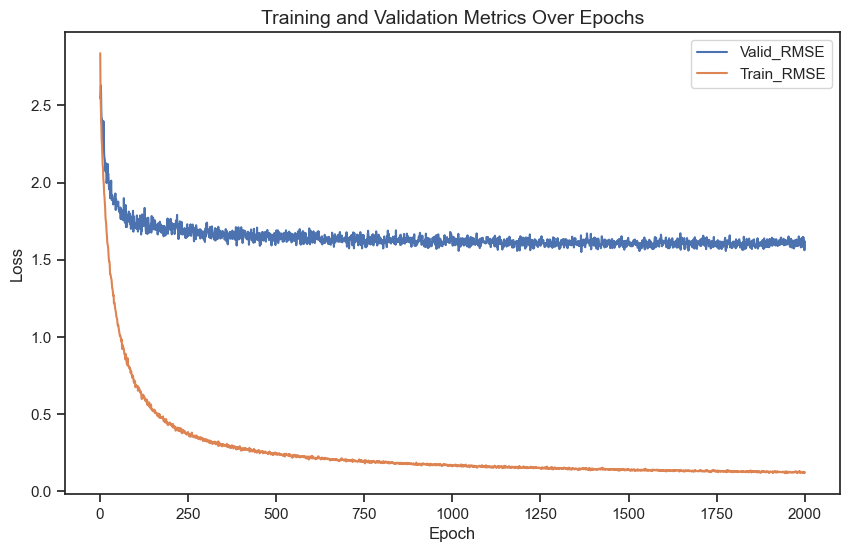

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
# Load metrics

metrics = train_history

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x='epoch', y='Val MSE', label='Valid_RMSE')
sns.lineplot(data=metrics, x='epoch', y='Train MSE', label='Train_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()


In [12]:
train_history.tail()

,epoch,Train Loss,Train MSE,Train MAE,Train RMSE,Train R2,Train Pearson,Train Median_AE,Train Explained_VARVal Loss,Val MSE,Val MAE,Val RMSE,Val R2,Val Pearson,Val Median_AE,Val Explained_VAR,Train Explained_VAR,Val Loss
1995,1996,0.126728,0.126742,0.262054,0.262054,0.967559,0.983646,0.204395,NaN,1.646109,0.926407,0.926407,0.588267,0.768888,0.679746,0.588275,0.967559,1.644423
1996,1997,0.119563,0.119577,0.256170,0.256170,0.969393,0.984578,0.197675,NaN,1.615105,0.922699,0.922699,0.596021,0.774079,0.673539,0.596047,0.969393,1.613621
1997,1998,0.122997,0.123005,0.260031,0.260031,0.968515,0.984132,0.200466,NaN,1.622323,0.925035,0.925035,0.594216,0.773303,0.684346,0.594316,0.968515,1.620892
1998,1999,0.118314,0.118316,0.255416,0.255416,0.969715,0.984742,0.196365,NaN,1.561977,0.914574,0.914574,0.609310,0.781687,0.663798,0.609468,0.969715,1.560796
1999,2000,0.123995,0.124005,0.257665,0.257665,0.968259,0.984002,0.196738,NaN,1.619998,0.913994,0.913994,0.594798,0.773761,0.665192,0.595335,0.968259,1.618768
